# Natural Language Processing: Week 2 - Word Embeddings

워드 임베딩(Word Embedding)은 단어를 벡터로 표현하는 방법으로, One-Hot 형태의 Sparse Vector가 아닌 Dense Vector 형태로 나타내는 과정이다.

이 밀집 벡터를 워드 임베딩 과정을 통해 나온 결과라고 하여 임베딩 벡터(embedding vector)라고도 한다.



머신 러닝에서 텍스트 분류. 그 중에서도 특히, 감성 분류를 연습하기 위해 자주 사용하는 데이터에는 영화 사이트 IMDB의 리뷰 데이터가 있다. 

이 데이터는 리뷰에 대한 텍스트와 해당 리뷰가 긍정인 경우 1을 부정인 경우 0으로 표시한 레이블로 구성된 데이터이다.

스탠포드 대학교에서 2011년에 낸 논문에서 이 데이터를 소개하였으며, 당시 논문에서는 이 데이터를 훈련 데이터와 테스트 데이터를 50:50대 비율로 분할하여 88.89%의 정확도를 얻었다고 소개하고 있다.

논문 링크 : http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf

텐서플로우에서는 해당 데이터를 바로 받아볼 수 있도록 지원하고 있으며, 이를 이용하여 실습을 진행해보도록 하겠다.

In [52]:
import numpy as np
import tensorflow as tf
tf.__version__
# 본인의 텐서플로우 버전이 1.X인 경우 다음을 실행하자
# tf.enable_eager_execution()

'2.6.0'

## Load Dataset

해당 데이터는 25,000개의 train sample과 25,000개의 test sample로 나뉜다

In [53]:
import tensorflow_datasets as tfds

imdb, info = tfds.load("imdb_reviews", with_info = True, as_supervised = True)

In [54]:
# Split Dataset
train_data, test_data = imdb['train'], imdb['test']

In [55]:
# Converting

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s, l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())

for s, l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())

In [56]:
# labels to Numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [57]:
# define 
vocab_size = 10_000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_token = '<OOV>'

# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length)

In [58]:
# define Neural Network

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

## How can we use vectors?

현재 우리의 데이터셋은 해당 리뷰의 긍, 부정을 레이블로 나타내고 있다. 즉, 감성 분석의 답변을 제공하고 있는데, 이때 부정적인 리뷰라고 레이블되어 있는 sentence에서 자주 등장하는 단어는 부정적인 감정을 지녔다고 판단되게 된다.

비슷한 감정을 지닌 단어들의 벡터는 유사한 경향을 보이게 되며, 이는 Neural Network 학습에서 이용되게 된다.

In [59]:
# Model Compile & Summary
model.compile(
    loss='binary_crossentropy', 
    optimizer = 'adam', 
    metrics = ['accuracy']
    )

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 11526     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [60]:
num_epochs = 10
model.fit(padded,
          training_labels_final,
          epochs = num_epochs,
          validation_data = (testing_padded, testing_labels_final)
          )

Epoch 1/10
782/782 [==============================] - 5s 6ms/step - loss: 0.4987 - accuracy: 0.7378 - val_loss: 0.3624 - val_accuracy: 0.8392
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.2475 - accuracy: 0.9050 - val_loss: 0.3636 - val_accuracy: 0.8404
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1046 - accuracy: 0.9716 - val_loss: 0.4411 - val_accuracy: 0.8274
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0301 - accuracy: 0.9955 - val_loss: 0.5139 - val_accuracy: 0.8265
Epoch 5/10
782/782 [==============================] - 4s 6ms/step - loss: 0.0101 - accuracy: 0.9989 - val_loss: 0.5845 - val_accuracy: 0.8249
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0039 - accuracy: 0.9997 - val_loss: 0.6404 - val_accuracy: 0.8220
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.6925 - val_accuracy: 0.8238
Epoch 

In [61]:
e = model.layers[0]
weights = e.get_weights()[0]

print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


## Write the vectors and their metadata auto files

In [62]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
  return " ".join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[0]))
print(training_sentences[0])

? ? b this was an absolutely terrible movie don't be <OOV> in by christopher walken or michael <OOV> both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the <OOV> rebels were making their cases for <OOV> maria <OOV> <OOV> appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining <OOV> like christopher <OOV> good name i could barely sit through it
b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pa

In [63]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + '\n')
  out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')

out_v.close()
out_m.close()

In [64]:
# import files

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[TensorFlow projector](https://projector.tensorflow.org)

## Classifier for the sarcasm dataset

In [65]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [66]:
# define
vocab_size = 10_000
embedding_dim = 16
max_length = 100
padding_type = 'post'
oov_token = '<OOV>'
training_size = 20_000

In [67]:
# sarcasm.json
!gdown --id 1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v

Downloading...
From: https://drive.google.com/uc?id=1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v
To: /content/sarcasm.json
100% 5.64M/5.64M [00:00<00:00, 88.5MB/s]


In [68]:
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [69]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [70]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [71]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [72]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [73]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [74]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.6767 - accuracy: 0.5623 - val_loss: 0.6378 - val_accuracy: 0.6260
Epoch 2/30
625/625 - 2s - loss: 0.4673 - accuracy: 0.8020 - val_loss: 0.3886 - val_accuracy: 0.8381
Epoch 3/30
625/625 - 2s - loss: 0.3165 - accuracy: 0.8724 - val_loss: 0.3532 - val_accuracy: 0.8508
Epoch 4/30
625/625 - 2s - loss: 0.2648 - accuracy: 0.8965 - val_loss: 0.3503 - val_accuracy: 0.8465
Epoch 5/30
625/625 - 2s - loss: 0.2293 - accuracy: 0.9096 - val_loss: 0.3537 - val_accuracy: 0.8435
Epoch 6/30
625/625 - 2s - loss: 0.2018 - accuracy: 0.9229 - val_loss: 0.3473 - val_accuracy: 0.8536
Epoch 7/30
625/625 - 2s - loss: 0.1807 - accuracy: 0.9305 - val_loss: 0.3568 - val_accuracy: 0.8536
Epoch 8/30
625/625 - 2s - loss: 0.1608 - accuracy: 0.9412 - val_loss: 0.3701 - val_accuracy: 0.8542
Epoch 9/30
625/625 - 2s - loss: 0.1443 - accuracy: 0.9483 - val_loss: 0.3896 - val_accuracy: 0.8504
Epoch 10/30
625/625 - 2s - loss: 0.1321 - accuracy: 0.9524 - val_loss: 0.4059 - val_accuracy: 0.8512

### Visualize

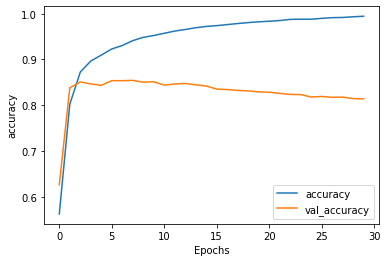

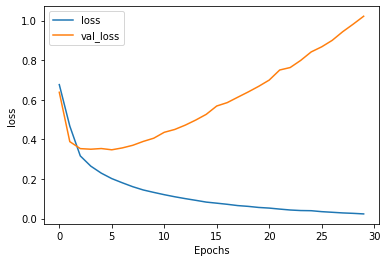

In [75]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [76]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [77]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [78]:
import io

out_v = io.open('vecs2.tsv', 'w', encoding='utf-8')
out_m = io.open('meta2.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [79]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs2.tsv')
  files.download('meta2.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[9.5524836e-01]
 [1.7991662e-04]]


[TensorFlow projector](https://projector.tensorflow.org)